In [60]:
import pandas as pd
import seaborn as sns
import collections
sns.set()

In [85]:
seed_cost = pd.read_csv("exp_0002_seed_cost.csv", names=["MaxTries", "NbCalls"])
seed_cost["goodness_ratio"] = seed_cost["MaxTries"]/seed_cost["NbCalls"]
seed_cost.mean()

MaxTries          113.950617
NbCalls           157.666667
goodness_ratio      0.722593
dtype: float64

72 % of the random seed points do converge. This is a pretty easy slide to pack.

In [96]:
call_cost = pd.read_csv("exp_0002_call-cost.csv", names=["Seed", "Convergence", "Metric", "NbCalls"])
call_cost["Metric"] = call_cost.apply(lambda row: float(row["Metric"][:-2]), axis=1)
call_cost["Convergence"] = call_cost.apply(lambda row: "tolerance=0.1" if "BURMEN" in row["Convergence"] else \
                                           "volume=0.1" if "PP-VOLUME" in row["Convergence"]  else row["Convergence"], axis=1)
call_cost.head()

Seed    Convergence    Metric  \
0  #(0.09159552843463745d0 0.6083346904231648d0)  tolerance=0.1  0.612651   
1  #(0.2517080347142392d0 0.10790000225296792d0)  tolerance=0.1  0.903051   
2   #(0.8608911591225213d0 0.1356435083117089d0)  tolerance=0.1  0.595926   
3   #(0.5443999026493731d0 0.5574582686972067d0)  tolerance=0.1  0.508158   
4   #(0.9317249885872684d0 0.5749653562734515d0)  tolerance=0.1  0.257379   

   NbCalls  
0        8  
1        7  
2        7  
3        8  
4       45

<AxesSubplot:xlabel='NbCalls', ylabel='Count'>

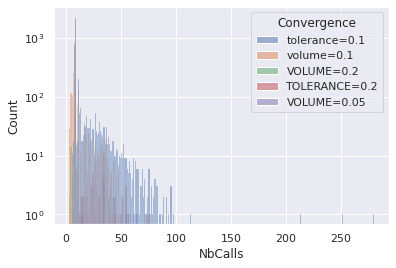

In [97]:
sns.histplot(data=call_cost, x="NbCalls", binwidth=1, log_scale=(False, True), hue="Convergence")

It is clear that the volume convergence criterion converges more quickly, and with fewer outliers. What about the quality of the results ?

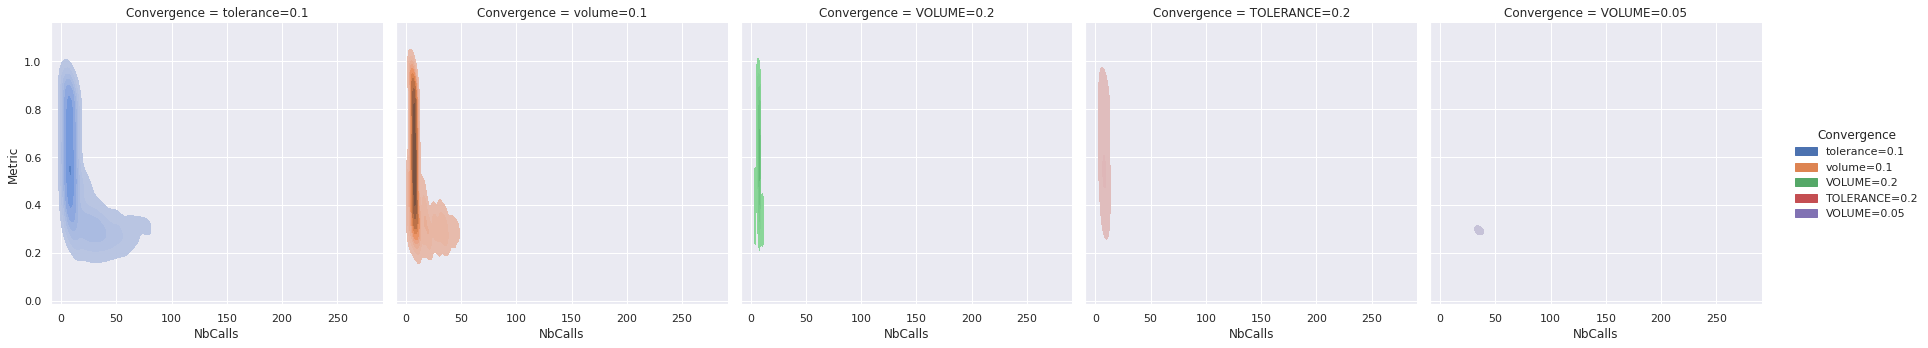

In [98]:
sns.displot(data=call_cost,
             kind="kde",
             x="NbCalls", y="Metric",
              fill=True,
              col="Convergence",
              hue="Convergence")

There is no significant loss of performance, but a significant reduction in the number of calls when using the volume.

Note that is is for a single run of the search function. Let's see how this sums up over many runs

In [99]:
data_exp1 = pd.read_csv("exp_0001.csv", names=["MaxTries", "MaxNoImprov", "MaxIt", "NbCalls", "Metric"])
data_exp2 = pd.read_csv("exp_0002.csv", names=["MaxTries", "MaxNoImprov", "MaxIt", "NbCalls", "Metric", "Convergence"])
data = pd.concat([data_exp1, data_exp2])
data["Convergence"] = data.apply(lambda row: row["Convergence"] if row["Convergence"] == row["Convergence"] else row["MaxIt"], axis=1)
data["Metric"] = data.apply(lambda row: float(row["Metric"][:-2]), axis=1)
max_table = data.groupby(by=["MaxTries", "MaxNoImprov", "Convergence"]).max().query("Metric <= .3")
max_table

MaxIt  NbCalls    Metric
MaxTries MaxNoImprov Convergence                            
30       30          30                30      551  0.294121
                     100              100     1083  0.281089
                     300              300     2155  0.292903
                     VOLUME=0.05      300     1121  0.256198
                     tolerance=0.1    300      578  0.267227
100      30          30                30     1277  0.268365
                     100              100     2695  0.277661
                     300              300     4160  0.260600
         100         10                10      977  0.290658
                     30                30     1620  0.260083
                     100              100     3047  0.261728
                     300              300     6418  0.258478
                     tolerance=0.1    300     1972  0.255295
                     volume=0.1       300     1246  0.269736
300      30          10                10      668  0.299525
                     30                30      960  0.274425
                     100              100     2055  0.288882
                     300              300     5230  0.259792
         100         10                10     2129  0.266004
                     30                30     4365  0.256079
                     100              100     7858  0.261428
                     300              300    12171  0.253423
         300         10                10     2772  0.262155
                     30                30     4469  0.250686
                     100              100     8349  0.233107
                     300              300    17768  0.220249
                     tolerance=0.1    300     5037  0.208677
                     volume=0.1       300     3447  0.253655

In [66]:
data.transform({k: str if k not in ["NbCalls", "Metric"] else lambda x:x for k in data.columns}, axis=0).query("MaxNoImprov == MaxTries")

MaxTries MaxNoImprov MaxIt  NbCalls    Metric    Convergence
40       10          10    10       89  0.327937             10
41       10          10    10       89  0.360991             10
42       10          10    10      102  0.309484             10
43       10          10    10      101  0.264263             10
44       10          10    10       82  0.219398             10
..      ...         ...   ...      ...       ...            ...
50      300         300   300     4386  0.199153  tolerance=0.1
51      300         300   300     3447  0.208668     volume=0.1
52      300         300   300     4502  0.204409  tolerance=0.1
53      300         300   300     3006  0.237827     volume=0.1
54      300         300   300     4934  0.208677  tolerance=0.1

[285 rows x 6 columns]

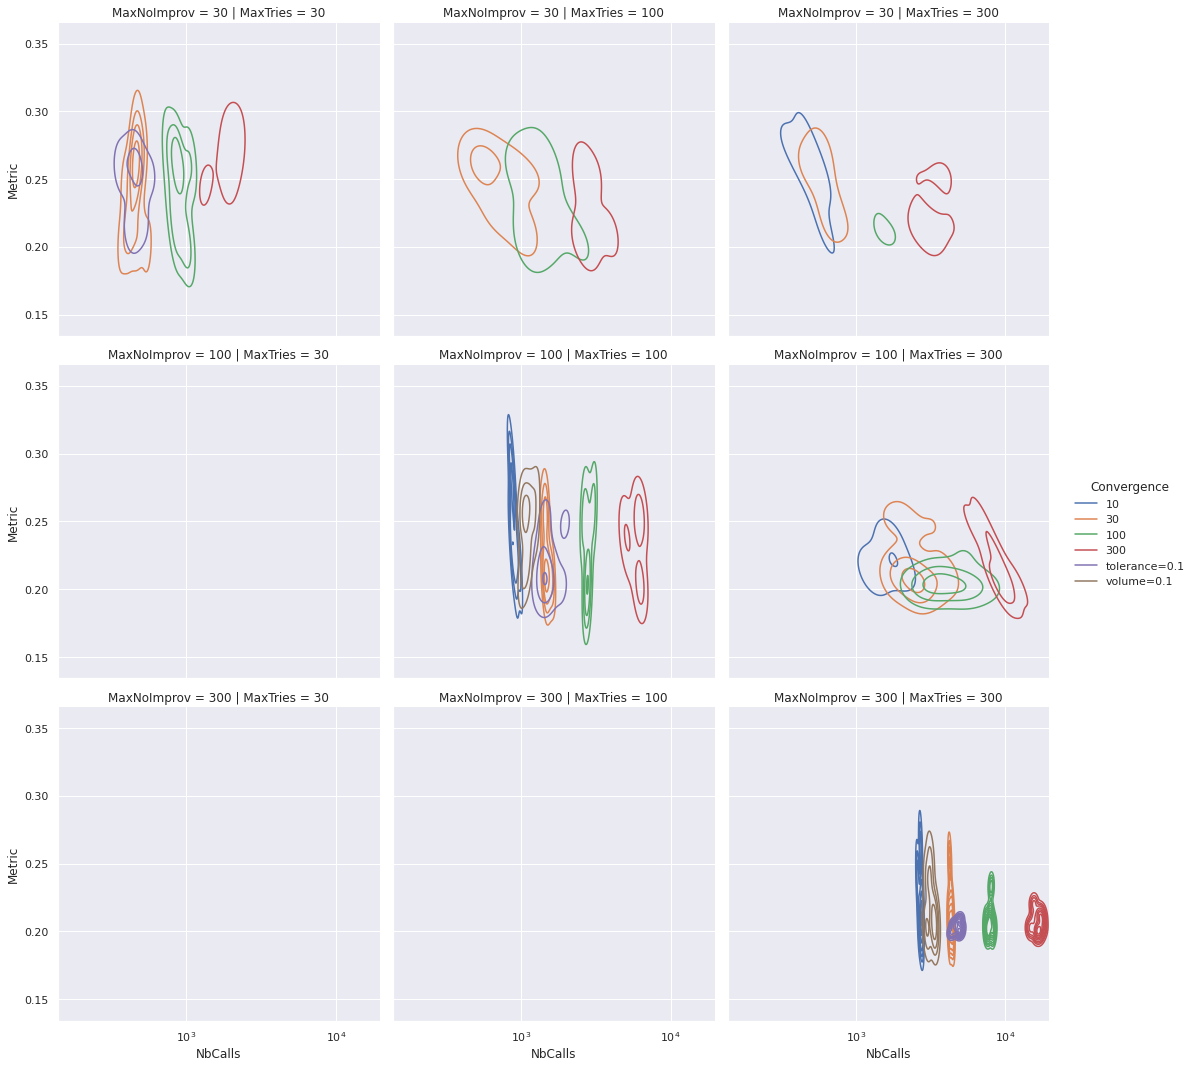

In [100]:
sns.displot(data=data[data.apply(lambda row: (row["MaxTries"], row["MaxNoImprov"], row["Convergence"]) in max_table.index, axis=1)]\
            .transform({k: str if k not in ["NbCalls", "Metric"] else lambda x:x for k in data.columns}, axis=0),
              kind="kde", 
            col="MaxTries", col_order=["30", "100", "300"],
            row="MaxNoImprov", x="NbCalls", y="Metric", #fill=True, 
            hue="Convergence",
            hue_order = ["10", "30", "100", "300", "tolerance=0.1", "volume=0.1"],
           log_scale=(True, False)
           )

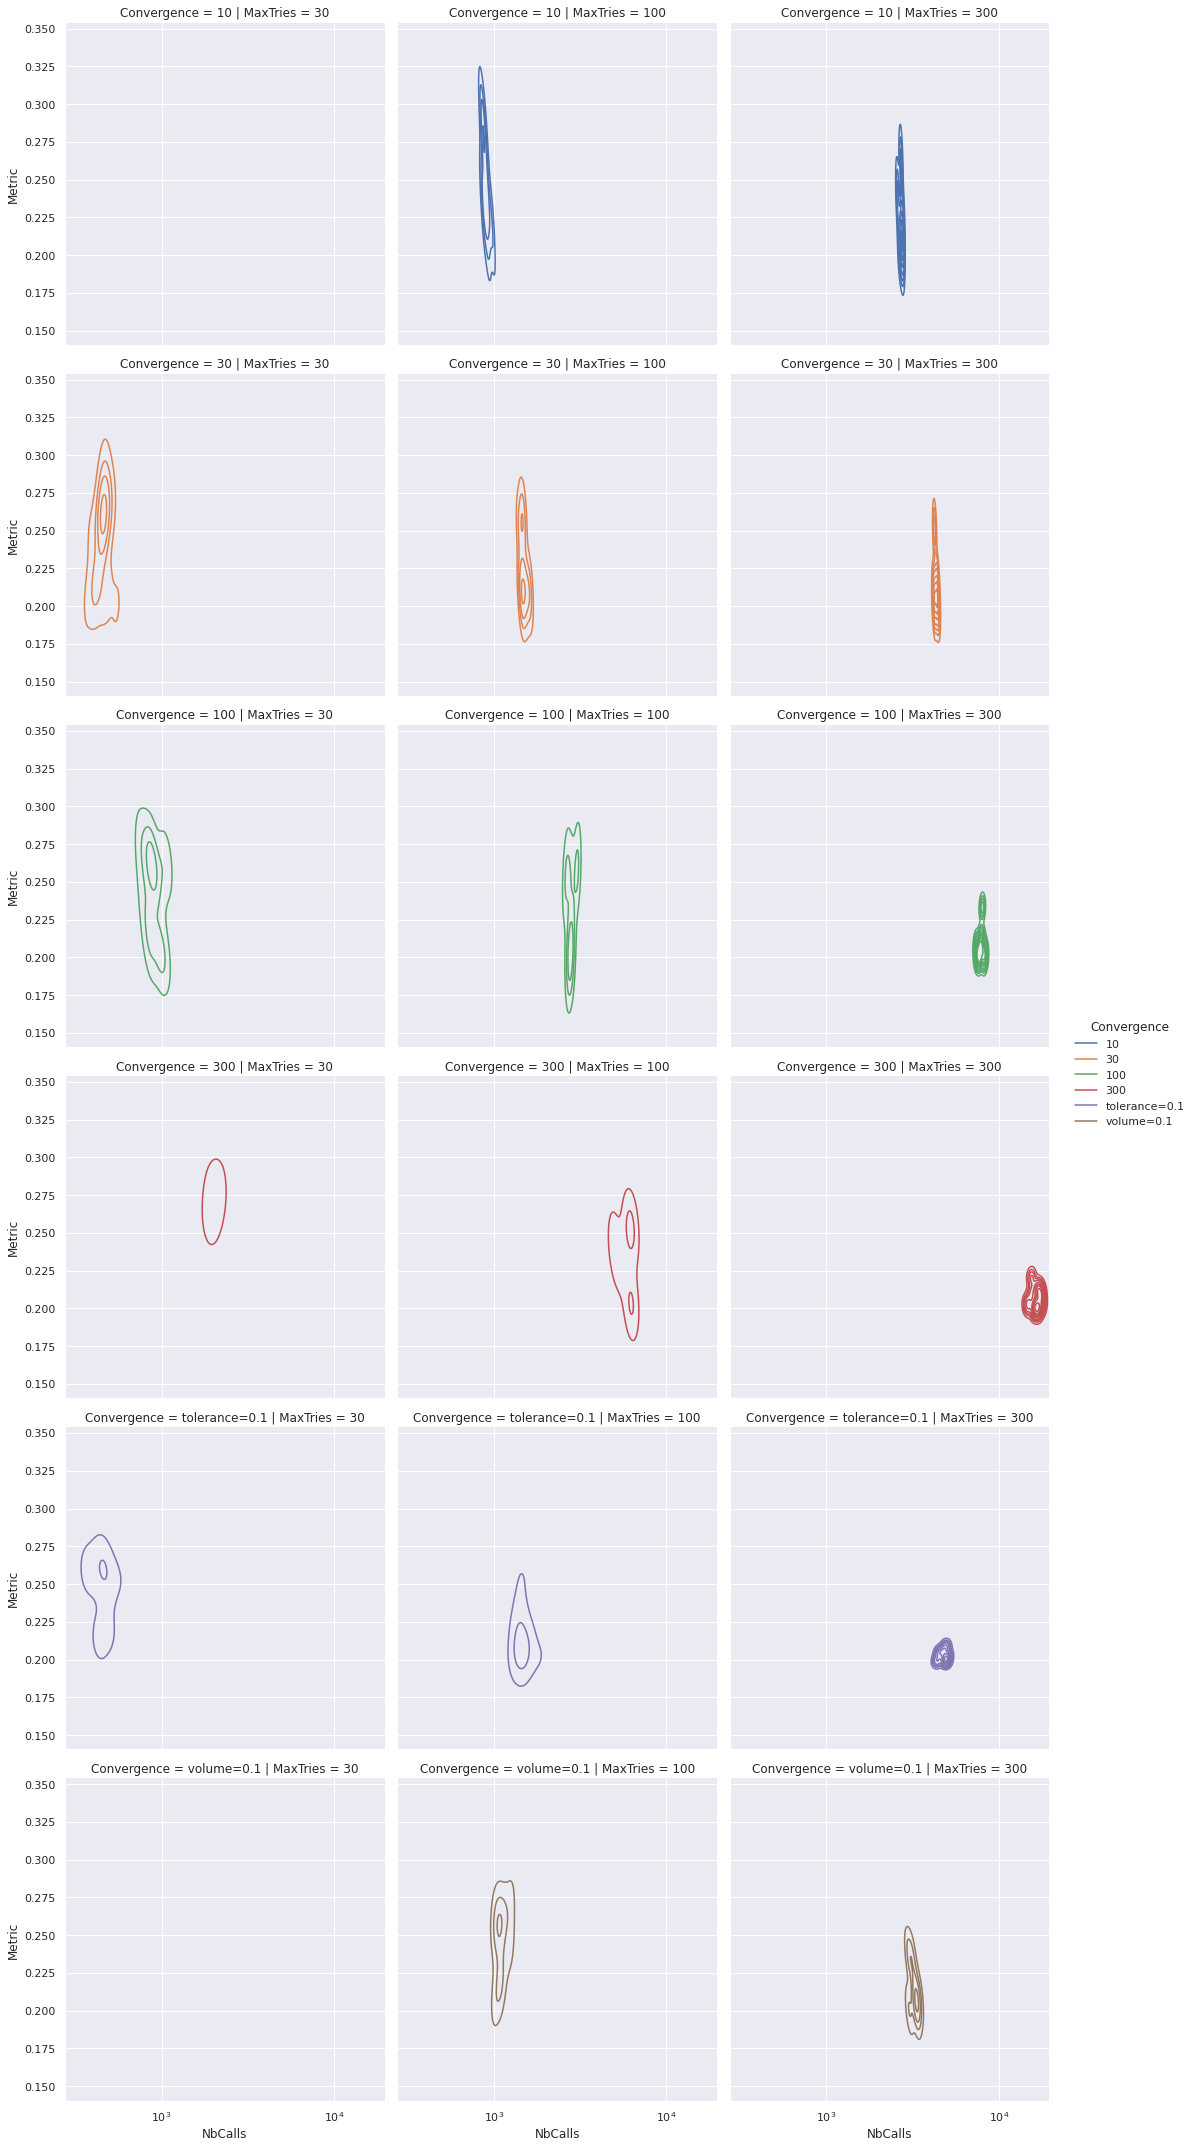

In [68]:
sns.displot(data=data[data.apply(lambda row: (row["MaxTries"], row["MaxNoImprov"], row["Convergence"]) in max_table.index, axis=1)]\
            .transform({k: str if k not in ["NbCalls", "Metric"] else lambda x:x for k in data.columns}, axis=0)\
            .query("MaxNoImprov == MaxTries"),
              kind="kde", 
            col="MaxTries", col_order=["30", "100", "300"],
            row="Convergence",
                      row_order = ["10", "30", "100", "300", "tolerance=0.1", "volume=0.1"],
                      x="NbCalls", y="Metric", #fill=True, 
            hue="Convergence",
            hue_order = ["10", "30", "100", "300", "tolerance=0.1", "volume=0.1"],
           log_scale=(True, False)
           )

The new code is faster and better than the old one. So let's use that as the baseline now.

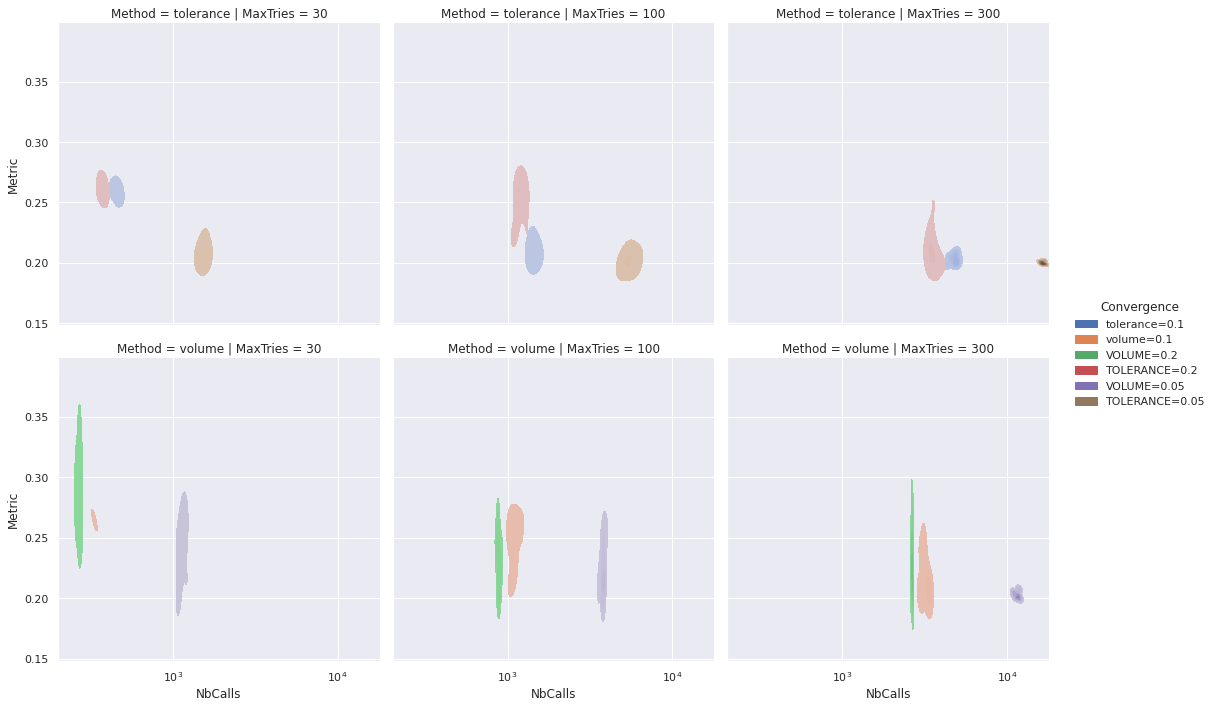

In [119]:
data_exp2 = pd.read_csv("exp_0002.csv", names=["MaxTries", "MaxNoImprov", "MaxIt", "NbCalls", "Metric", "Convergence"])
data_exp2["Metric"] = data_exp2.apply(lambda row: float(row["Metric"][:-2]), axis=1)
data_exp2["Method"] = data_exp2.apply(lambda row: "volume" if "volume" in row["Convergence"].lower() else "tolerance", axis=1)
sns.displot(data=data_exp2,
              kind="kde", 
                col="MaxTries", #col_order=["30", "100", "300"],
           x="NbCalls", y="Metric", fill=True, 
            row="Method",
            hue="Convergence",
           log_scale=(True, False)
           )

We have two pareto optimal solutions. Maybe by playing with the volume value we could get something that pareto dominates both solutions.

No luck with the pareto domination, we seem to be walking on the pareto frontier. It could be nice if we could express the compromise as a simple budget, expressed in number of calls to the SAT sovler, and walk the pareto frontier and get the best solution given the budget.

That will be the topic of another experiment.

We 